# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
labels.sample(10)

file_name  real_age
5060  005060.jpg        21
3926  003926.jpg        16
1647  001647.jpg        34
715   000715.jpg        17
5877  005878.jpg        27
3779  003779.jpg        31
2768  002768.jpg        28
190   000190.jpg        65
1520  001520.jpg        38
5594  005594.jpg        33

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
features, target = next(train_gen_flow)

In [6]:
features.shape

(32, 224, 224, 3)

Text(0, 0.5, 'кол-во людей')

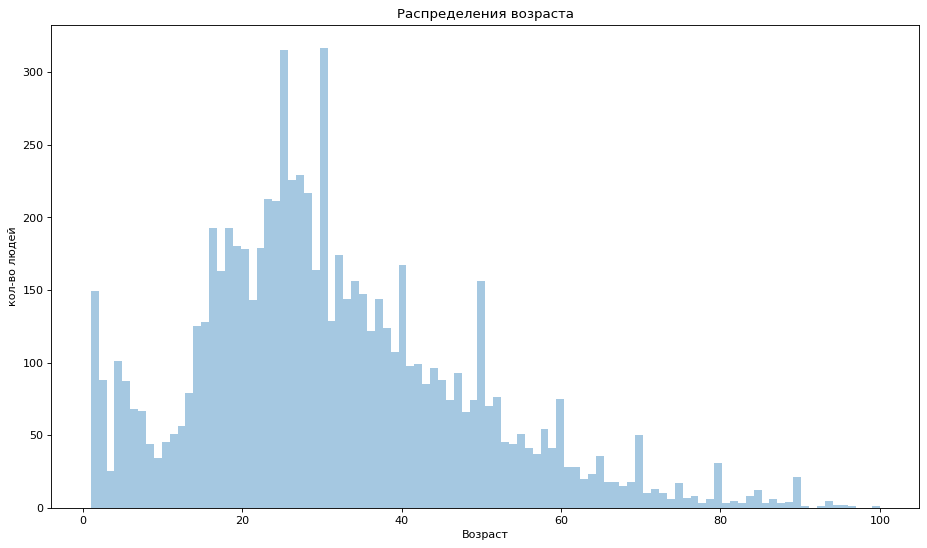

In [7]:
plt.figure(figsize=(14,8), dpi=80)
sns.distplot(labels['real_age'], bins=100, kde=False)
plt.title("Распределения возраста")
plt.xlabel("Возраст")
plt.ylabel("кол-во людей")

Видим, что распределение около нормальное с правым хвостом. Выбросы в районе 80 лет. 

Text(0.5, 0, 'Возраст')

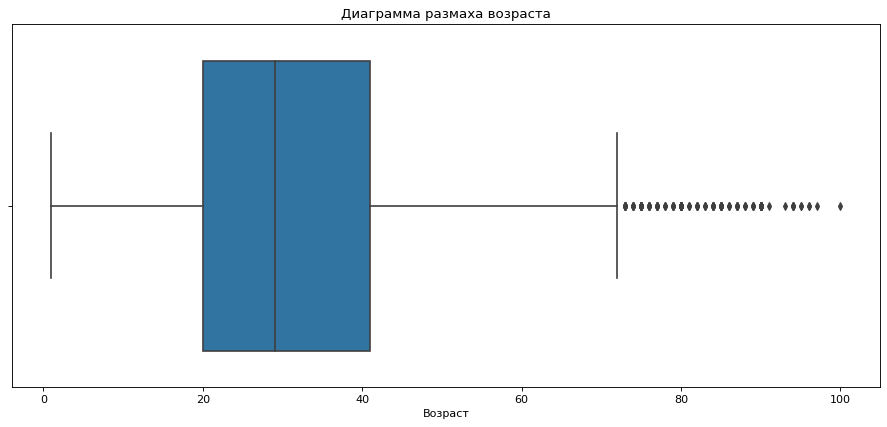

In [8]:
plt.figure(figsize=(14,6), dpi=80)
sns.boxplot(labels['real_age'])
plt.title("Диаграмма размаха возраста")
plt.xlabel("Возраст")

Медианный возраст около 27 лет. 

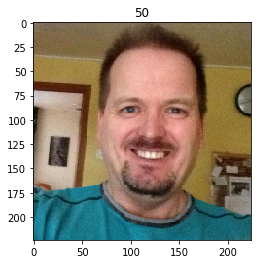

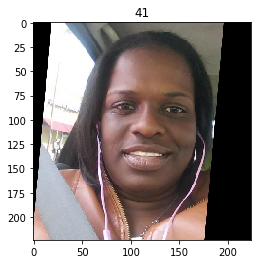

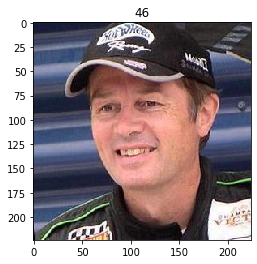

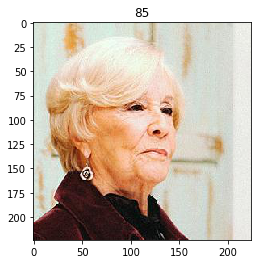

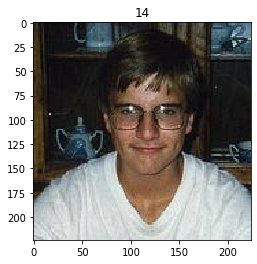

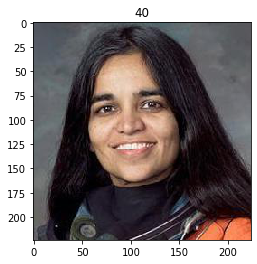

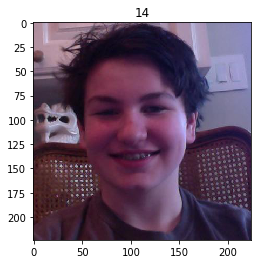

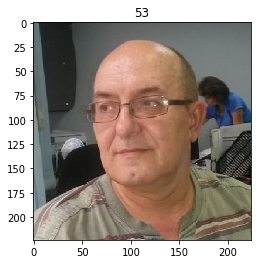

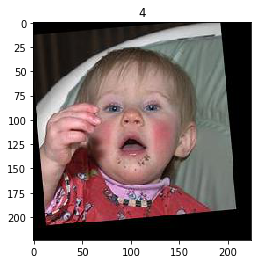

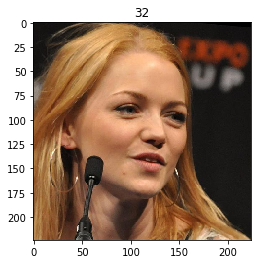

In [9]:
for i in range(10):           
    plt.imshow(features[i])
    plt.title(target[i])  
    plt.show()

В выборке присутсвуют как чёрно-белые картинки, так и искаженные изначально.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import numpy as np
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, AvgPool2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        horizontal_flip=True,
        seed=42)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42)

    return test_datagen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape= input_shape,
                    weights='imagenet',
                    include_top= False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model



```

```

178/178 - 44s - loss: 221.2822 - mae: 10.6782 - val_loss: 894.2912 - val_mae: 24.9386
Epoch 2/10
178/178 - 36s - loss: 58.8988 - mae: 5.8425 - val_loss: 884.0043 - val_mae: 24.7538
Epoch 3/10
178/178 - 36s - loss: 30.3899 - mae: 4.2783 - val_loss: 313.8053 - val_mae: 13.0392
Epoch 4/10
178/178 - 37s - loss: 19.9985 - mae: 3.4611 - val_loss: 123.0368 - val_mae: 8.7505
Epoch 5/10
178/178 - 37s - loss: 14.5933 - mae: 2.9781 - val_loss: 92.5859 - val_mae: 7.2889
Epoch 6/10
178/178 - 37s - loss: 12.7462 - mae: 2.7836 - val_loss: 75.2873 - val_mae: 6.7278
Epoch 7/10
178/178 - 36s - loss: 10.8918 - mae: 2.5315 - val_loss: 73.3964 - val_mae: 6.5351
Epoch 8/10
178/178 - 36s - loss: 9.8175 - mae: 2.3863 - val_loss: 67.8539 - val_mae: 6.2123
Epoch 9/10
178/178 - 37s - loss: 9.0282 - mae: 2.2797 - val_loss: 74.1207 - val_mae: 6.4151
Epoch 10/10
178/178 - 37s - loss: 8.6490 - mae: 2.1722 - val_loss: 72.3417 - val_mae: 6.4097

```

## Анализ обученной модели

Итак, мы достигли того показателя метрики, который нам был нужен. MAE на валидационной выборке достигла 6.4097. Для обучения использовалисверточную нейронную сеть resnet50. Алгоритмом оптимизации выступала адаптивная оценка момента с lr=0.0001. Обучение проходило на 10 эпохах.